# Ordered Logistic Regression

In [2]:
import arviz as az
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import numpyro
import numpyro.distributions as dist
import pandas as pd
import scipy
import scipy.stats as stats
import seaborn as sns
from numpyro import handlers
from numpyro.infer.reparam import TransformReparam
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker

numpyro.set_host_device_count(4)
az.style.use("arviz-darkgrid")

Some data on how people respond to a questionnaire

- 0 - not satsified
- 1 - kinda satisfied
- 2 - totally satisfied

features:
- number of hours that people work

is it regression? no.
is it classification? kinda.

## Generate data

In [3]:
n_samples = 112
hours_worked = stats.norm(35, 3).rvs(size=n_samples)
survey_response_raw = 3 + 1.1 * hours_worked + stats.norm(0, 0.5).rvs(n_samples)
survey_response = np.where(
    survey_response_raw < 37,
    0,
    np.where(survey_response_raw < 42, 1, 2),
)

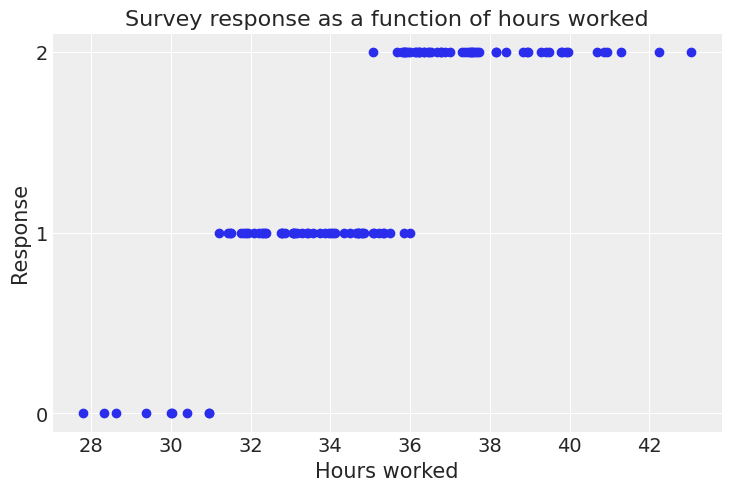

In [4]:
fig, ax = plt.subplots()
ax.plot(hours_worked, survey_response, "o");
ax.set_xlabel('Hours worked')
ax.set_ylabel('Response');
ax.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
ax.set_title('Survey response as a function of hours worked');

### Train-test split

In [5]:
data = pd.DataFrame({"hours_worked": hours_worked, "response": survey_response})

In [6]:
train = data.sample(frac=0.8).copy().reset_index(drop=True)
test = data.loc[~data.index.isin(train.index)].copy().reset_index(drop=True)

train["hours_worked_scaled"] = (
    train["hours_worked"] - train["hours_worked"].mean()
) / train["hours_worked"].std()
test["hours_worked_scaled"] = (
    test["hours_worked"] - train["hours_worked"].mean()
) / train["hours_worked"].std()

In [7]:
train.shape, test.shape

((90, 3), (22, 3))

In [8]:
train

,hours_worked,response,hours_worked_scaled
0,34.014437,1,-0.329728
1,34.340198,1,-0.226029
2,32.213995,1,-0.902862
3,42.237544,2,2.287930
4,36.476364,2,0.453976
...,...,...,...
85,41.295628,2,1.988090
86,37.549676,2,0.795643
87,34.843087,1,-0.065945
88,35.834956,2,0.249797


## Categorical Distribution

In [14]:
samples = dist.Categorical(probs=jnp.array([.2, .5, .3])).sample(jax.random.PRNGKey(9), sample_shape=(1_000_000,))
samples

DeviceArray([2, 1, 1, ..., 1, 1, 1], dtype=int32)

In [15]:
pd.Series(samples).value_counts(normalize=True).sort_index()

0    0.200669
1    0.499250
2    0.300081
dtype: float64

## Back to our problem

Should be try predicting these probabilities directly?
Maybe not, maybe we need some additional structure to capture the ordering among them.



In [16]:
train["response"].value_counts(normalize=True).sort_index()

0    0.088889
1    0.477778
2    0.433333
Name: response, dtype: float64

In [17]:
train["response"].value_counts(normalize=True).sort_index().cumsum()

0    0.088889
1    0.566667
2    1.000000
Name: response, dtype: float64

In [19]:
scipy.special.logit(train["response"].value_counts(normalize=True).sort_index().cumsum())

0   -2.327278
1    0.268264
2         inf
Name: response, dtype: float64

```
p_0: probablity of survey response 0
p_1: probablity of survey response 1
p_2: probablity of survey response 2
```
cumsum gives us:
```
q_0: probablity of survey response 0
q_1: probablity of survey response 1 or 0
q_2: probablity of survey response 2 or 1 or 0
```

`q_2` has to be 1, so we only need to bother with predicting q_0 and q_1

`q_0` and `q_1` are probabilties, so they need to be between 0 and 1. Which is inconvenient for a regression task.

Apply the logit transform such that `q_0` and `q_1` are unconstrained.

Then, we're gonna want to use our feature (`hours_worked`).

    prediction = coefficient * hours_worked
    q_0 = f(cutpoint_0, prediction)
    q_1 = f(cutpoint_1, prediction)
    
`f` chosen to be `cutpoint - prediction`:

    prediction = coefficient * hours_worked
    q_0 = cutpoint_0 - prediction
    q_1 = cutpoint_1 - prediction

In [41]:
def ordered_logistic_regression(hours_worked_scaled, n_responses, response=None):
    n_samples = len(hours_worked_scaled)
    
    coefficient = numpyro.sample(
        'coefficient',
        dist.Normal(loc=0, scale=1),
    )
    cutpoints = numpyro.sample(
        'cutpoints',
        dist.TransformedDistribution(
            dist.Normal(loc=0, scale=1).expand([n_responses-1]),
            dist.transforms.OrderedTransform(),
        ),
    )
    
    predictions = coefficient * hours_worked_scaled
    assert predictions.shape == (n_samples,)
    assert cutpoints.shape == (n_responses-1,)

    cumulative_logits = cutpoints - predictions[:, jnp.newaxis]
    assert cumulative_logits.shape == (n_samples, n_responses-1)
    
    cumulative_probs = jnp.pad(
        jax.scipy.special.expit(cumulative_logits),
        pad_width=((0, 0), (1, 1)),
        constant_values=(0, 1),
    )
    probs = numpyro.deterministic(
        'probs',
        jnp.diff(cumulative_probs, axis=1),
    )
    assert probs.shape == (n_samples, n_responses)
    
    numpyro.sample(
        'response',
        dist.Categorical(probs=probs),
        obs=response,
    )

In [42]:
prior_pred = numpyro.infer.Predictive(ordered_logistic_regression, num_samples=100)
hours_worked_scaled = np.linspace(-3, 3, num=100)
prior_predictions = prior_pred(
    jax.random.PRNGKey(93),
    hours_worked_scaled=hours_worked_scaled,
    n_responses=3,
)

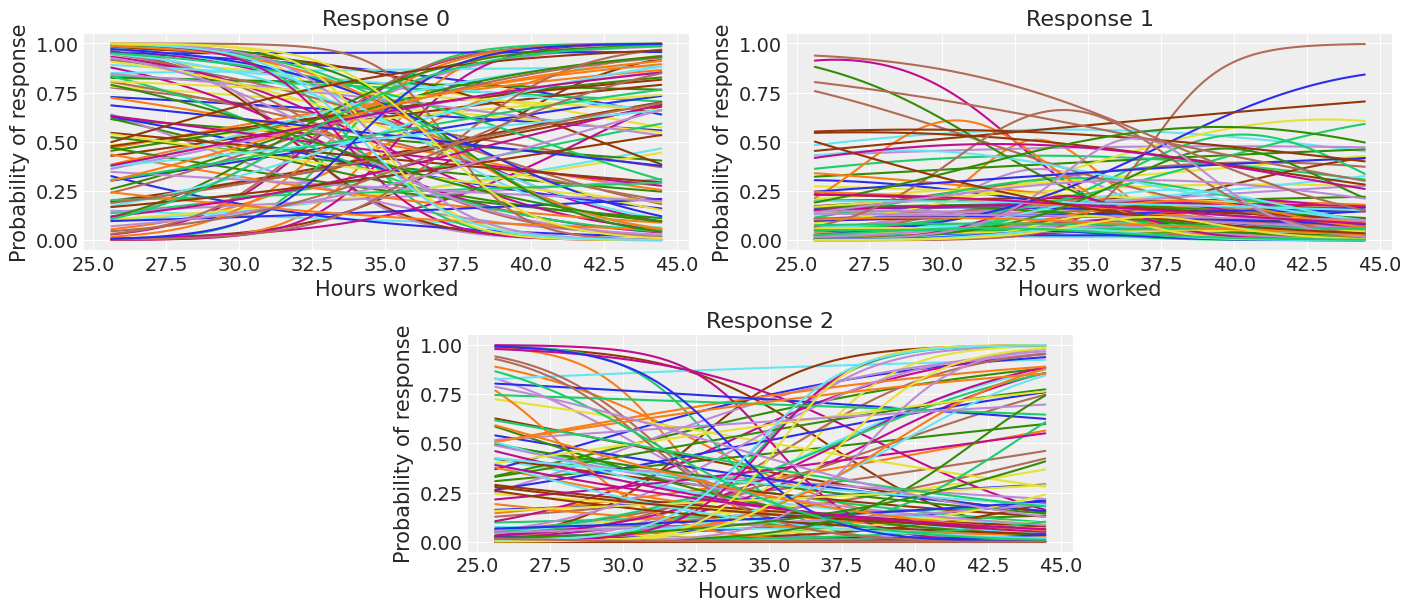

In [43]:
fig = plt.figure(figsize=(14, 6))
hours_worked = hours_worked_scaled*train['hours_worked'].std() + train['hours_worked'].mean()

gs = gridspec.GridSpec(4, 4, figure=fig)
ax = []
ax.append(fig.add_subplot(gs[:2, :2]))
ax.append(fig.add_subplot(gs[:2, 2:], sharey=ax[0]))
ax.append(fig.add_subplot(gs[2:, 1:3]))

for response in (0, 1, 2):
    ax[response].plot(
        hours_worked,
        prior_predictions["probs"][:, :, response].T,
    )
    ax[response].set_xlabel("Hours worked")
    ax[response].set_ylabel("Probability of response")
    ax[response].set_title(f'Response {response}')

In [44]:
sampler = numpyro.infer.NUTS(ordered_logistic_regression)
mcmc = numpyro.infer.MCMC(sampler, num_chains=4, num_samples=1000, num_warmup=1000)
mcmc.run(
    jax.random.PRNGKey(93),
    hours_worked_scaled=train["hours_worked_scaled"].to_numpy(),
    n_responses=3,
    response=train["response"].to_numpy(),
)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [45]:
mcmc.print_summary()


                   mean       std    median      5.0%     95.0%     n_eff     r_hat
  coefficient      2.96      0.42      2.96      2.27      3.62   1199.21      1.00
 cutpoints[0]     -3.82      0.49     -3.80     -4.58     -3.00   1033.46      1.00
 cutpoints[1]      0.51      0.30      0.51      0.05      1.02   3939.99      1.00

Number of divergences: 0


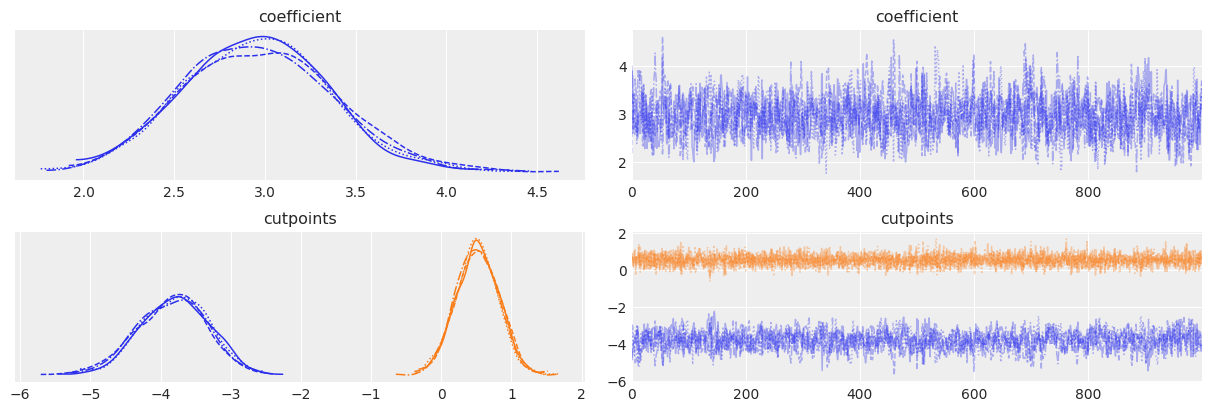

In [47]:
az.plot_trace(az.from_numpyro(mcmc), var_names=["~probs"]);

In [48]:
post_pred = numpyro.infer.Predictive(ordered_logistic_regression, mcmc.get_samples())
post_predictions = post_pred(
    jax.random.PRNGKey(93),
    hours_worked_scaled=train["hours_worked_scaled"].to_numpy(),
    n_responses=3,
)

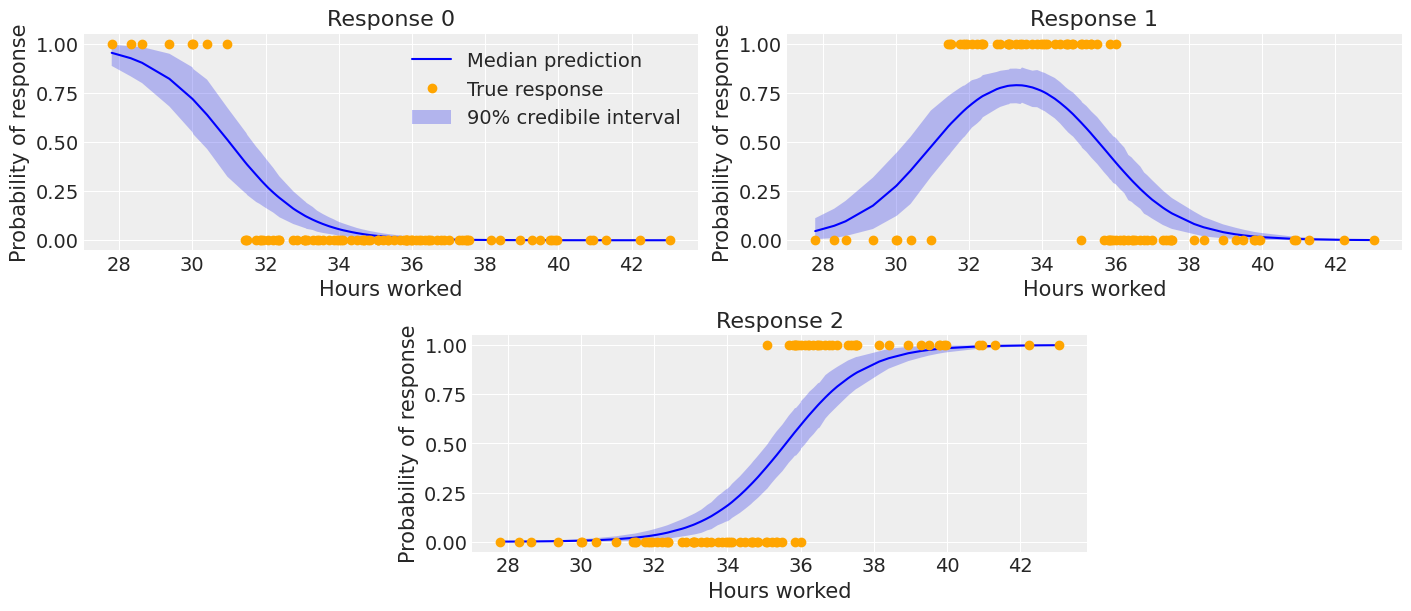

In [49]:
fig = plt.figure(figsize=(14, 6))
idx = train["hours_worked"].sort_values().index

gs = gridspec.GridSpec(4, 4, figure=fig)
ax = []
ax.append(fig.add_subplot(gs[:2, :2]))
ax.append(fig.add_subplot(gs[:2, 2:], sharey=ax[0]))
ax.append(fig.add_subplot(gs[2:, 1:3]))

for response in (0, 1, 2):
    ax[response].fill_between(
        train.loc[idx, "hours_worked"],
        *numpyro.diagnostics.hpdi(post_predictions["probs"][:, idx.to_numpy(), response]),
        alpha=.3,
        label="90% credibile interval"
    )
    ax[response].plot(
        train.loc[idx, "hours_worked"],
        jnp.median(post_predictions["probs"][:, idx.to_numpy(), response], axis=0),
        color="blue",
        label="Median prediction",
    )
    true =  pd.concat(
        [pd.get_dummies(train["response"], prefix="response"), train["hours_worked"]],
        axis=1,
    ).loc[idx]#.plot.scatter(x="hours_worked", y=f"response_{response}", ax=ax[response], c='orange', label=f'True response of {response}')
    ax[response].plot(train.loc[idx, 'hours_worked'], true[f'response_{response}'], 'o', c='orange', label=f'True response')
    ax[response].set_xlabel("Hours worked")
    ax[response].set_ylabel("Probability of response")
    if response == 0:
        ax[response].legend();
    ax[response].set_title(f'Response {response}')

## But wait!

I said at the start that we had a test set. Let's check our predictions on it.

In [52]:
post_pred = numpyro.infer.Predictive(ordered_logistic_regression, mcmc.get_samples())
post_predictions = post_pred(
    jax.random.PRNGKey(93),
    hours_worked_scaled=test["hours_worked_scaled"].to_numpy(),
    n_responses=3,
)

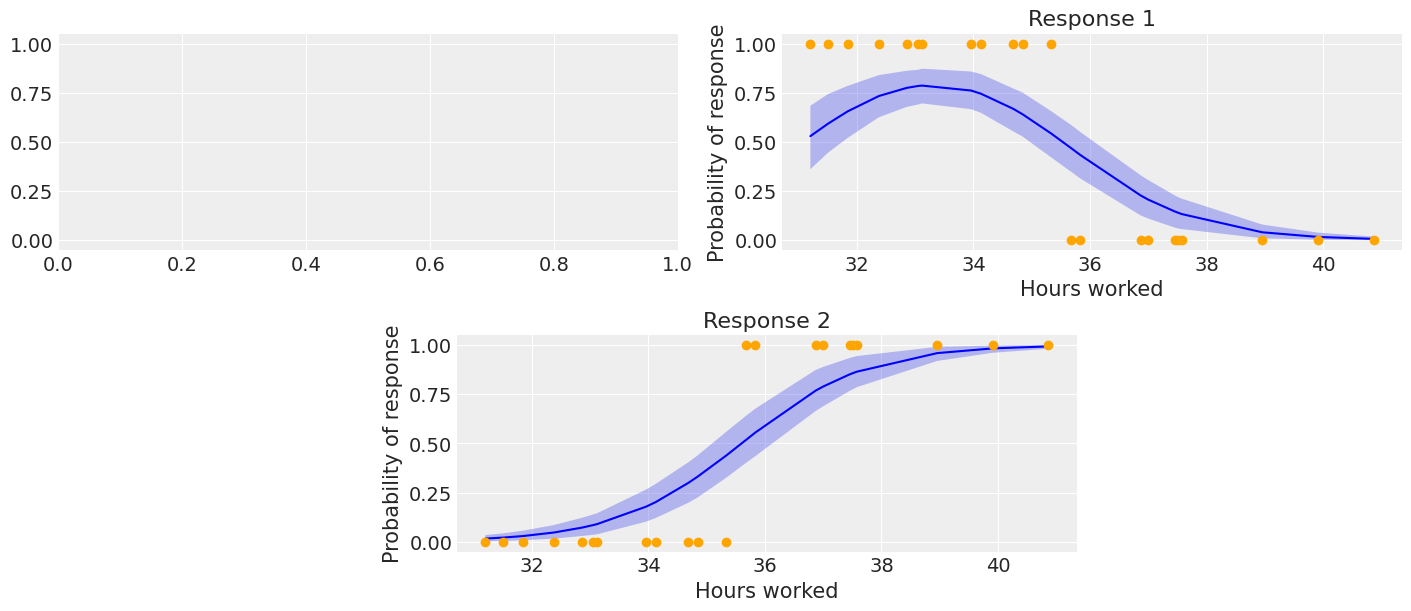

In [54]:
fig = plt.figure(figsize=(14, 6))
idx = test["hours_worked"].sort_values().index

gs = gridspec.GridSpec(4, 4, figure=fig)
ax = []
ax.append(fig.add_subplot(gs[:2, :2]))
ax.append(fig.add_subplot(gs[:2, 2:], sharey=ax[0]))
ax.append(fig.add_subplot(gs[2:, 1:3]))

for response in test['response'].unique():
    ax[response].fill_between(
        test.loc[idx, "hours_worked"],
        *numpyro.diagnostics.hpdi(post_predictions["probs"][:, idx.to_numpy(), response]),
        alpha=.3,
        label="90% credibile interval"
    )
    ax[response].plot(
        test.loc[idx, "hours_worked"],
        jnp.median(post_predictions["probs"][:, idx.to_numpy(), response], axis=0),
        color="blue",
        label="Median prediction",
    )
    true =  pd.concat(
        [pd.get_dummies(test["response"], prefix="response"), test["hours_worked"]],
        axis=1,
    ).loc[idx]
    ax[response].plot(test.loc[idx, 'hours_worked'], true[f'response_{response}'], 'o', c='orange', label=f'True response')
    ax[response].set_xlabel("Hours worked")
    ax[response].set_ylabel("Probability of response")
    if response == 0:
        ax[response].legend();
    ax[response].set_title(f'Response {response}')

## Resources

Statistical Rethinking, by Richard McElreath (life-changing book)

Betancourt's case studies